[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Olesik_et_al_2022/demo_make_convergences.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Olesik_et_al_2022/demo_make_convergences.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Olesik_et_al_2022/demo_make_convergences.ipynb)

see [Olesik et al. 2022](https://doi.org/10.5194/gmd-15-3879-2022)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import os
import warnings
import numpy as np
from numba.core.errors import NumbaExperimentalFeatureWarning
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot
from joblib import Parallel, parallel_backend, delayed
from PyMPDATA.options import Options
from PyMPDATA_examples.Olesik_et_al_2022.settings import Settings, default_opt_set, option_string
from PyMPDATA_examples.Olesik_et_al_2022.coordinates import x_p2
from PyMPDATA_examples.Olesik_et_al_2022.simulation import Simulation
from PyMPDATA_examples.Olesik_et_al_2022.equilibrium_drop_growth import PdfEvolver
from PyMPDATA_examples.utils.discretisation import discretised_analytical_solution
from PyMPDATA_examples.utils.error_norms import Smolarkiewicz_Grabowski_1990_eq21

In [3]:
CI = 'CI' in os.environ
GCs = np.linspace(.05,.95, 3) if CI else np.linspace(.05,.95, 7)
nrs = np.array([2**n for n in (range(7, 10) if CI else range(7,15))], dtype=int)

In [4]:
grid_layout = x_p2()
psi_coord = x_p2()
settings = Settings()

In [5]:
const = min(np.log2(1/nrs)) - 1


def phi(cour):
    return cour * np.pi / 2

def rho(n):
    return np.log2(1/n) - const


def polar_plot(nr, cour, values, name):
    theta_array = phi(cour)
    r_array = rho(nr)

    X, Y = np.meshgrid(theta_array, r_array)
    Z = np.array(list(values)).reshape(len(r_array), len(theta_array))

    min_val = -26
    max_val = -2

    amplitude = max_val - min_val
    if name == 'log$_2$(err)':
        levels = np.linspace(
            min_val,
            max_val,
            int(amplitude + 1)
        )
    else:
        levels = 7

    ax = plt.subplot(111, projection='polar')
    cnt = ax.contourf(X, Y, Z, levels, cmap='jet')
    plt.contour(X, Y, Z, levels, colors='black')
    ax.scatter(X, Y, alpha=.8, s=10)
    legend = plt.colorbar(cnt, ax=ax, pad=0.1)
    legend.set_label(r'$log_2(Err_{L2})$', rotation=90)
    ax.set_thetalim(min(theta_array),max(theta_array))
    ax.set_rlim(0, max(r_array))
    
    ticks = r_array
    ax.set_yticks(ticks)
    ax.set_yticklabels("$2^{" + f"{int(-tick - const):d}" + "}$" for tick in ticks)
    
    ax.set_thetagrids(cour * 90, tuple(f"{c:.2g}" for c in cour))
    ax.grid(True)
    ax.set_xlabel(r"$nx$", labelpad=18)
    ax.annotate(r'$C$', xy=(.8, .85), xycoords='axes fraction')

In [6]:
def analysis(settings, GC, opt):
    options = Options(**opt)
    simulation = Simulation(settings, grid_layout,  psi_coord, options, GC)
    simulation.step(simulation.out_steps[-1])
    t = simulation.out_steps[-1] * simulation.dt
    rh = simulation.rh
    pdf_t = PdfEvolver(settings.pdf, settings.drdt, t)
    def pdf_arg(r):
        return pdf_t(r* rh.units).magnitude
    analytical = discretised_analytical_solution(
                simulation.rh.magnitude,
                pdf_arg, midpoint_value = True,
                r=simulation.r.magnitude
            ) * pdf_t(rh[0]).units
    numerical = simulation.n_of_r
    error = np.log2(Smolarkiewicz_Grabowski_1990_eq21(numerical.magnitude, analytical.magnitude, t.magnitude))
    return settings.nr, GC, error

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-2)]: Done  41 out of  56 | elapsed:  7.5min remaining:  2.7min
[Parallel(n_jobs=-2)]: Done  47 out of  56 | elapsed:  8.8min remaining:  1.7min
[Parallel(n_jobs=-2)]: Done  53 out of  56 | elapsed:  9.7min remaining:   32.8s
[Parallel(n_jobs=-2)]: Done  56 out of  56 | elapsed:  9.8min finished


upwind


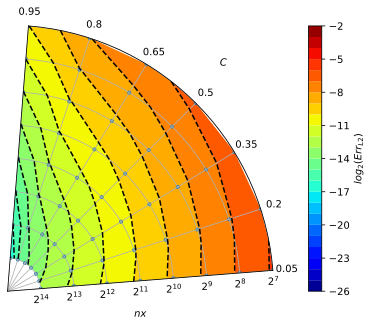

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-2)]: Done  41 out of  56 | elapsed:  3.2min remaining:  1.2min
[Parallel(n_jobs=-2)]: Done  47 out of  56 | elapsed:  4.8min remaining:   55.0s
[Parallel(n_jobs=-2)]: Done  53 out of  56 | elapsed:  5.9min remaining:   20.2s
[Parallel(n_jobs=-2)]: Done  56 out of  56 | elapsed:  6.1min finished


MPDATA 2 iterations


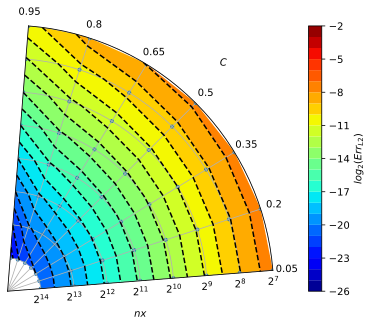

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-2)]: Done  41 out of  56 | elapsed:  3.4min remaining:  1.2min
[Parallel(n_jobs=-2)]: Done  47 out of  56 | elapsed:  5.0min remaining:   57.1s
[Parallel(n_jobs=-2)]: Done  53 out of  56 | elapsed:  6.2min remaining:   21.0s
[Parallel(n_jobs=-2)]: Done  56 out of  56 | elapsed:  6.3min finished


MPDATA 2 iterations infinite gauge


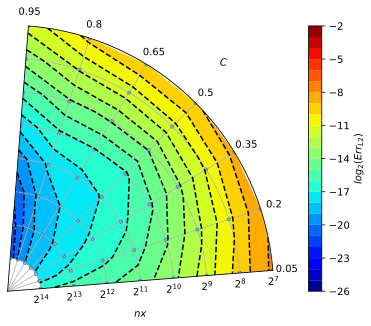

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-2)]: Done  41 out of  56 | elapsed:  3.5min remaining:  1.3min
[Parallel(n_jobs=-2)]: Done  47 out of  56 | elapsed:  4.9min remaining:   56.1s
[Parallel(n_jobs=-2)]: Done  53 out of  56 | elapsed:  6.4min remaining:   21.6s
[Parallel(n_jobs=-2)]: Done  56 out of  56 | elapsed:  6.6min finished


MPDATA 2 iterations infinite gauge non-oscillatory


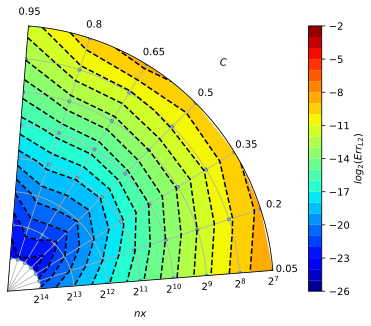

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-2)]: Done  41 out of  56 | elapsed:  3.6min remaining:  1.3min
[Parallel(n_jobs=-2)]: Done  47 out of  56 | elapsed:  4.8min remaining:   55.2s
[Parallel(n_jobs=-2)]: Done  53 out of  56 | elapsed:  6.3min remaining:   21.5s
[Parallel(n_jobs=-2)]: Done  56 out of  56 | elapsed:  6.6min finished


MPDATA 2 iterations DPDC infinite gauge non-oscillatory


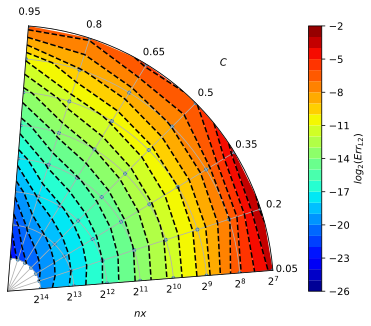

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-2)]: Done  41 out of  56 | elapsed:  3.3min remaining:  1.2min
[Parallel(n_jobs=-2)]: Done  47 out of  56 | elapsed:  5.0min remaining:   57.7s
[Parallel(n_jobs=-2)]: Done  53 out of  56 | elapsed:  6.3min remaining:   21.5s
[Parallel(n_jobs=-2)]: Done  56 out of  56 | elapsed:  6.5min finished


MPDATA 3 iterations third order terms


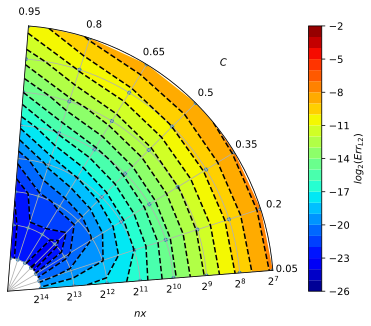

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-2)]: Done  41 out of  56 | elapsed:  4.1min remaining:  1.5min
[Parallel(n_jobs=-2)]: Done  47 out of  56 | elapsed:  5.7min remaining:  1.1min
[Parallel(n_jobs=-2)]: Done  53 out of  56 | elapsed:  6.9min remaining:   23.3s
[Parallel(n_jobs=-2)]: Done  56 out of  56 | elapsed:  7.1min finished


MPDATA 3 iterations


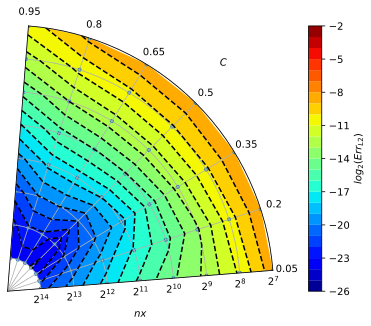

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-2)]: Done  41 out of  56 | elapsed:  4.0min remaining:  1.5min
[Parallel(n_jobs=-2)]: Done  47 out of  56 | elapsed:  5.8min remaining:  1.1min
[Parallel(n_jobs=-2)]: Done  53 out of  56 | elapsed:  6.9min remaining:   23.5s
[Parallel(n_jobs=-2)]: Done  56 out of  56 | elapsed:  7.1min finished


MPDATA 3 iterations third order terms infinite gauge non-oscillatory


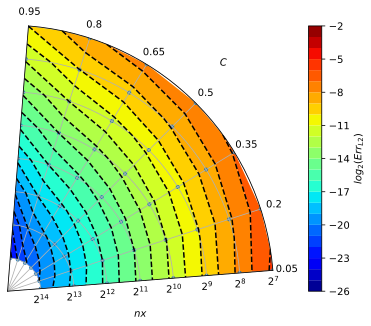

In [7]:
for opt in default_opt_set.values():
    with parallel_backend('threading', n_jobs=-2):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=NumbaExperimentalFeatureWarning)
            results0 = Parallel(verbose=10)(
                delayed(analysis)(Settings(nr = nr, mixing_ratios_g_kg = [1.05,]), GC, opt)
                for nr in nrs
                for GC in GCs
            )
    results = tuple(tuple(i) for i in zip(*results0))
    plot_setup = np.array(results[0:2])
    measures = {'log$_2$(err)':results[2]}
    opt=option_string(str(opt))
    print(opt)
    for k, measure in measures.items():
        polar_plot(nrs, GCs, measure, name=k)
        show_plot(filename = f'convergence_{k}_{opt}.pdf')